<div class="alert alert-warning">
<h2> СОВЕТ <a class="tocSkip"> </h2>
большинство графиков здесь интерактивные советую смотреть через nbviewer
</div>

#  Прогнозирование показателей счётчика

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение prophet" data-toc-modified-id="Обучение prophet-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение prophet </a></span></li><li><span><a href="#Обучение rnn" data-toc-modified-id="Обучение rnn-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение rnn</a></span></li>
<li><span><a href="#Обучение CatBoost" data-toc-modified-id="Обучение CatBoost-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение CatBoost</a></span></li>
<li><span><a href="#Интерпретация CatBoostRegressor" data-toc-modified-id="Интерпретация CatBoostRegressor-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Интерпретация CatBoostRegressor</a></span></li>
<li><span><a href="#Итоговый тест и вывод" data-toc-modified-id="Итоговый тест и вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Итоговый тест и вывод</a></span></li></ul></div>

Задача

1. Сделать прогноз временного ряда на следующие сутки. 
2. Выбрать метрику, оценить результат прогноза. 
3. Выполнить поиск аномальных значений временного ряда.
4. Построить на одном графике: временной ряд, прогноз, аномальные точки. 

Данные

`counter_timestamp` - дата и время  
`counter_data` - значения счетчика


## Подготовка

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objects as go
from ydata_profiling import ProfileReport
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from prophet import Prophet
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense,LSTM
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from catboost import CatBoostRegressor
%pylab inline

C:\ana\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\ana\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\ana\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('performance_data.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data

counter_data
counter_timestamp                
2022-02-21 16:15:00  10408.421667
2022-02-21 16:30:00  10493.064667
2022-02-21 16:45:00  10370.143667
2022-02-21 17:00:00  11169.873000
2022-02-21 17:15:00  11111.825000
...                           ...
2022-03-22 23:00:00           NaN
2022-03-22 23:15:00   1993.071000
2022-03-22 23:30:00   1573.885667
2022-03-22 23:45:00   1005.688000
2022-03-23 00:00:00   1618.347667

[2806 rows x 1 columns]

сразу в глаза бросается пропуск.
<br>пропуск - это аномалия , будем их фиксировать

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2806 entries, 2022-02-21 16:15:00 to 2022-03-23 00:00:00
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   counter_data  2778 non-null   float64
dtypes: float64(1)
memory usage: 43.8 KB


In [5]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

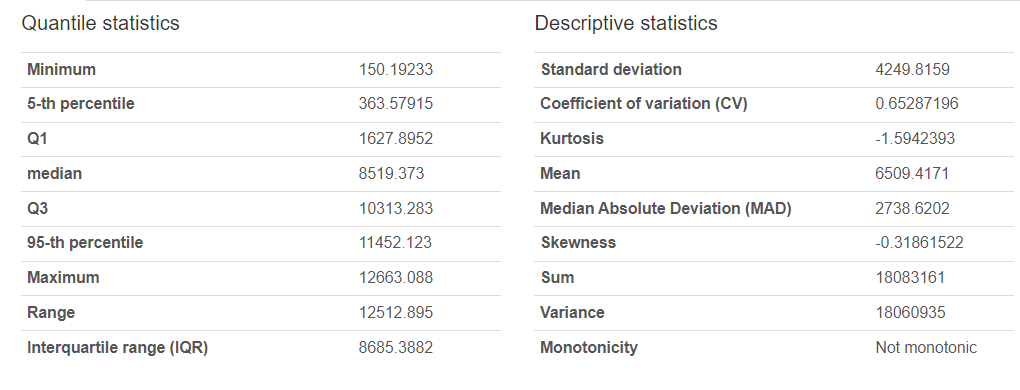

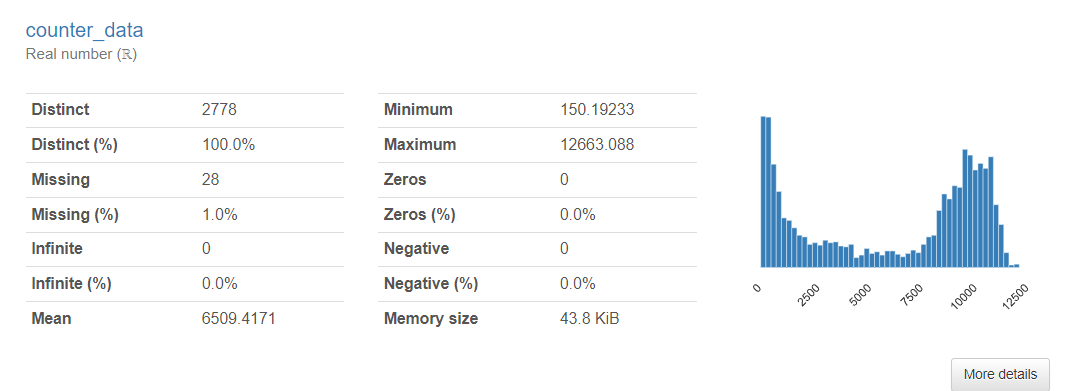

в выводе по блоку опишу то что вижу 

на всякий случай проверим что бед с индексом нет

In [6]:
data.index.is_monotonic

C:\Users\Алексей\AppData\Local\Temp\ipykernel_8772\3649924976.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  data.index.is_monotonic


True

In [7]:
fig = px.line(data, x=data.index, y='counter_data', title='counter results')

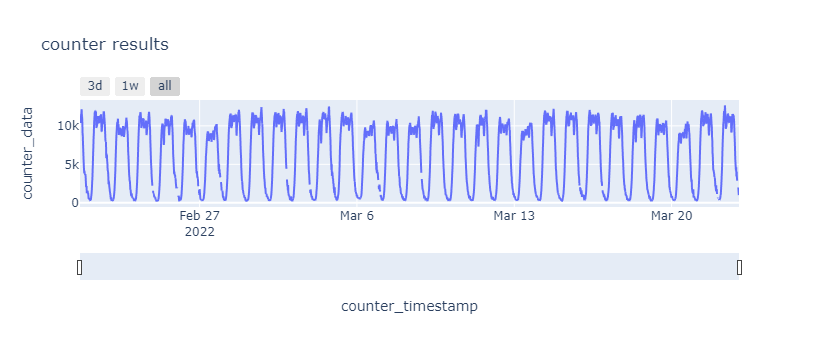

In [8]:
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"), # добавляем кнопки на график позволяющие менять быстро диапазон наблюдений
            dict(count=7, label="1w", step="day", stepmode="backward"), # добавляем кнопки на график позволяющие менять быстро диапазон наблюдений
            dict(step="all")
        ])
    )
)
fig.show()


наблюдение: в основном пропуски найденны ночью (причём до полуночи) я не знаю процессов , но могу предположить что были какие-то технические работы или открлючения детекции по другим причинам . Также это может говорить об определённых неисправностях 

<div class="alert alert-info">
<h2> Комментарий выполняющего: <a class="tocSkip"> </h2>
важно, всё что я говорю это лишь рассуждения без знания самого процесса
</div> 

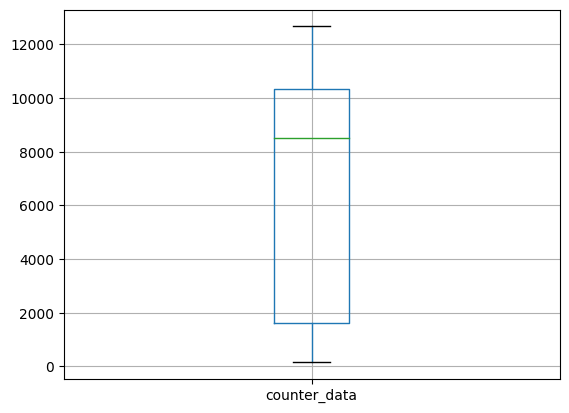

In [9]:
data.boxplot()
plt.show()

угу , выбросов нет 

In [10]:
index_nan = data[data['counter_data'].isna()]
index_nan

counter_data
counter_timestamp                
2022-02-24 21:45:00           NaN
2022-02-24 22:00:00           NaN
2022-02-25 23:45:00           NaN
2022-02-26 00:30:00           NaN
2022-02-26 00:45:00           NaN
2022-02-26 01:00:00           NaN
2022-02-26 22:45:00           NaN
2022-02-26 23:00:00           NaN
2022-02-27 22:30:00           NaN
2022-02-27 23:45:00           NaN
2022-02-28 00:00:00           NaN
2022-02-28 03:00:00           NaN
2022-03-01 23:00:00           NaN
2022-03-02 21:00:00           NaN
2022-03-03 21:45:00           NaN
2022-03-06 23:00:00           NaN
2022-03-07 01:00:00           NaN
2022-03-08 21:00:00           NaN
2022-03-15 22:00:00           NaN
2022-03-16 01:30:00           NaN
2022-03-16 02:00:00           NaN
2022-03-16 22:00:00           NaN
2022-03-22 00:00:00           NaN
2022-03-22 00:45:00           NaN
2022-03-22 01:45:00           NaN
2022-03-22 22:30:00           NaN
2022-03-22 22:45:00           NaN
2022-03-22 23:00:00           NaN

заполнение пропусков интерполяцией

In [11]:
data = data.interpolate(method='polynomial', order=2)

сохранение в отдельный датасет точек с выбросами , для дальнейшего вывода на графики

In [12]:
data_out = data[data.index.isin(index_nan.index)]
data_out

counter_data
counter_timestamp                
2022-02-24 21:45:00   1953.690541
2022-02-24 22:00:00   1800.421594
2022-02-25 23:45:00   2032.563663
2022-02-26 00:30:00   1760.398560
2022-02-26 00:45:00   1484.355495
2022-02-26 01:00:00   1178.610266
2022-02-26 22:45:00   1412.645006
2022-02-26 23:00:00   1092.715985
2022-02-27 22:30:00   3048.080574
2022-02-27 23:45:00   1331.993885
2022-02-28 00:00:00   1482.417188
2022-02-28 03:00:00    317.292051
2022-03-01 23:00:00   1129.299517
2022-03-02 21:00:00   3761.077590
2022-03-03 21:45:00   2004.963625
2022-03-06 23:00:00   2633.438720
2022-03-07 01:00:00   1245.226422
2022-03-08 21:00:00   3469.207707
2022-03-15 22:00:00   2241.448301
2022-03-16 01:30:00    878.771563
2022-03-16 02:00:00   1052.485598
2022-03-16 22:00:00   1825.889382
2022-03-22 00:00:00   2352.480024
2022-03-22 00:45:00    755.539100
2022-03-22 01:45:00    552.839436
2022-03-22 22:30:00   2754.918479
2022-03-22 22:45:00   2565.626590
2022-03-22 23:00:00   2308.405240

In [13]:
data.isna().sum()

counter_data    0
dtype: int64

отлично устранили пропуски, взляним на пропуски

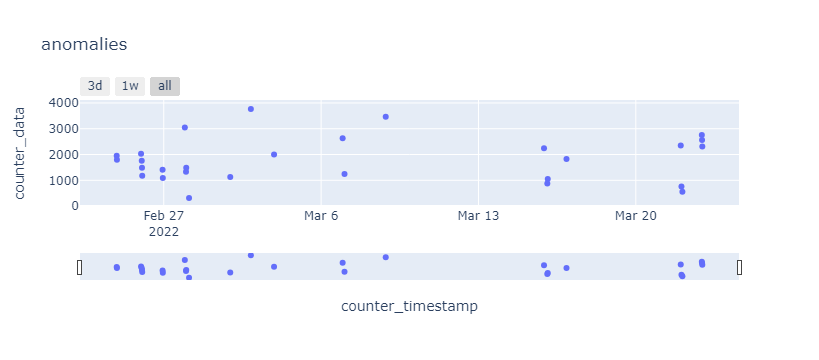

In [14]:
#fig = px.line(data, x=data.index, y='counter_data', title='num_orders for all the time')
fig = px.scatter(data_out, x=data_out.index, y='counter_data', title='anomalies')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"),
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

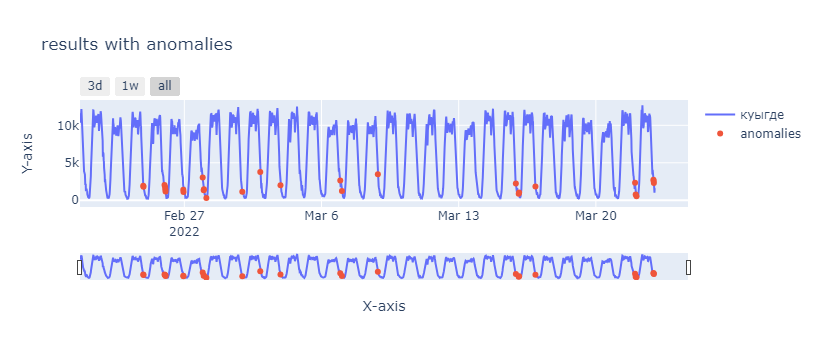

In [15]:
# Sample data
x_data1 = x=data.index
x_data2 = data_out.index
y_data_1 = data['counter_data']
y_data_2 = data_out['counter_data']

# Create traces for each data set
trace1 = go.Scatter(x=x_data1, y=y_data_1, mode='lines', name='result')
trace2 = go.Scatter(x=x_data2, y=y_data_2, mode='markers', name='anomalies')

# Create the figure and add traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout if needed (e.g., title, axis labels)
fig.update_layout(title='results with anomalies',
                  xaxis_title='X-axis',
                  yaxis_title='Y-axis')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"),
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

Вывод EDA + заполнения: 
<br>проблем с типом данных нет (индекс - data , значение - float) 
<br>в столбцах которые будем использовать для построение моделей было обнаруженно и заполено интерполяцией 28 пропусков 
<br>явные дубликаты отсутствуют 
<br>странных значений обнаружено не было (нет значений выбивающихся из временного ряда + нарушающие сезонность , также нет нулевых значений , минимальное и максимальное значение находится недалеко от 5 и 95 перцентиля соответсвенно , что говорит об отсутсвие экстремально больших или маленьких значений

Дальнейший план: проведём ресэмплинг и проверим на стационарность ряд

## Анализ

давайте проверим ряд на стационарность (визуально видно , что он стационарен , но вдруг мы что-то не правильно интерпретировали)

H0 : временной ряд содержит единичные корни, т.е., он нестационарен.
<br>H1 : временной ряд лишен единичных корней, т.е., он стационарен. 
<br>alpha = 0.05

In [16]:
result = adfuller(data['counter_data'])

In [17]:
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -13.660930614204672
p-value: 1.5219542949639378e-25
Critical Values: {'1%': -3.43270698773957, '5%': -2.862581350327331, '10%': -2.5673243433645037}


значение статистики ADF значительно меньше критических значений , это может свидетельствовать о стационарности временного ряда. Также  p-value меньше выбранного уровня значимости , это может указывать на стационарность временного ряда, и нулевую гипотезу о наличии единичных корней можно отвергнуть.

In [18]:
data

counter_data
counter_timestamp                
2022-02-21 16:15:00  10408.421667
2022-02-21 16:30:00  10493.064667
2022-02-21 16:45:00  10370.143667
2022-02-21 17:00:00  11169.873000
2022-02-21 17:15:00  11111.825000
...                           ...
2022-03-22 23:00:00   2308.405240
2022-03-22 23:15:00   1993.071000
2022-03-22 23:30:00   1573.885667
2022-03-22 23:45:00   1005.688000
2022-03-23 00:00:00   1618.347667

[2806 rows x 1 columns]

горизонт прогнозирования сутки , это 96 временных точек , ужас) нужен resample хотя бы почасовой. 24 Точки конечно не сок , но это и не почти 100)

In [19]:
data = data.resample('1H').sum()

In [20]:
data

counter_data
counter_timestamp                
2022-02-21 16:00:00  31271.630001
2022-02-21 17:00:00  45465.502000
2022-02-21 18:00:00  45091.751334
2022-02-21 19:00:00  31916.051666
2022-02-21 20:00:00  19101.347001
...                           ...
2022-03-22 20:00:00  19620.574334
2022-03-22 21:00:00  15462.083333
2022-03-22 22:00:00  11133.987069
2022-03-22 23:00:00   6881.049907
2022-03-23 00:00:00   1618.347667

[705 rows x 1 columns]

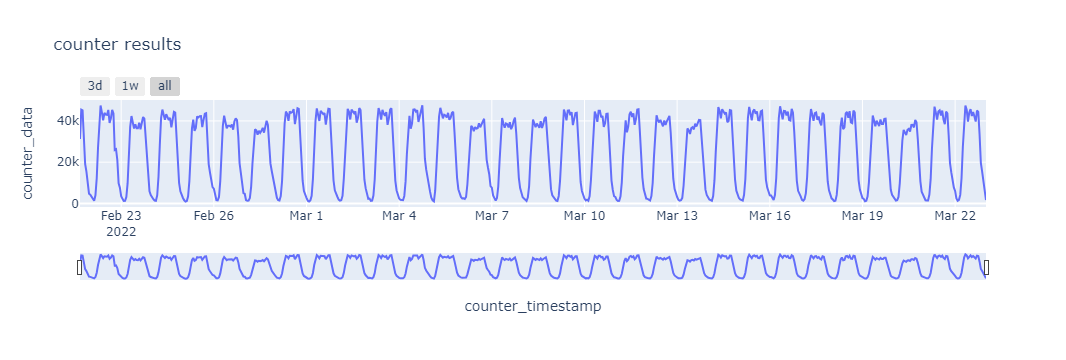

In [21]:
fig = px.line(data, x=data.index, y='counter_data', title='counter results')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"),
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

временной ряд не имеет визуальных изменений после resample , единственное что , интересный нюанс обычно счётчик имеет спад с приблизительно 18:00 до 2-3 часов ночи , как правило это происходит с плавным убыванием значения , но 22 февраля значение счётчика в 19 было больше чем в 18 
<br> 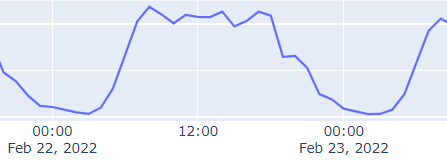

также нужно сопоставить аномалии с новым данными

In [22]:
data_out.index = data_out.index.floor('H')
data_out = data[data.index.isin(index_nan.index)]
data_out

counter_data
counter_timestamp                
2022-02-24 22:00:00   5889.760261
2022-02-26 01:00:00   3791.489266
2022-02-26 23:00:00   5023.265651
2022-02-28 00:00:00   5497.438521
2022-02-28 03:00:00   1384.188384
2022-03-01 23:00:00   4249.178517
2022-03-02 21:00:00  11472.199590
2022-03-06 23:00:00   8436.474720
2022-03-07 01:00:00   3832.774088
2022-03-08 21:00:00  11530.582040
2022-03-15 22:00:00   7677.866967
2022-03-16 02:00:00   3002.560597
2022-03-16 22:00:00   6127.690382
2022-03-22 00:00:00   6063.174790
2022-03-22 23:00:00   6881.049907

давайте убедимся что на графике всё выводит корректно 

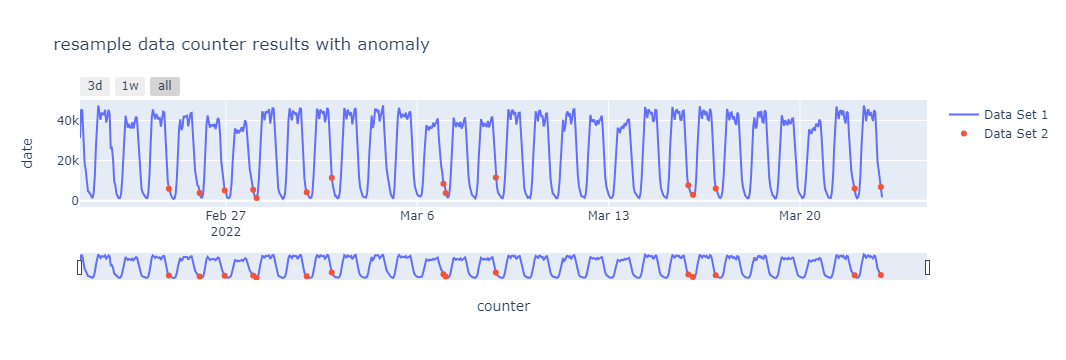

In [23]:
x_data1 = x=data.index
x_data2 = data_out.index
y_data_1 = data['counter_data']
y_data_2 = data_out['counter_data']

# Create traces for each data set
trace1 = go.Scatter(x=x_data1, y=y_data_1, mode='lines', name='Data Set 1')
trace2 = go.Scatter(x=x_data2, y=y_data_2, mode='markers', name='Data Set 2')

# Create the figure and add traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout if needed (e.g., title, axis labels)
fig.update_layout(title='resample data counter results with anomaly',
                  xaxis_title='counter',
                  yaxis_title='date')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"),
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

всё совпало , супер

осталось посмотреть сезонности и тренды с шумом , мне не особо нравится как работает seasonal_decompose , но что поделать

In [24]:
decomposed = seasonal_decompose(data)

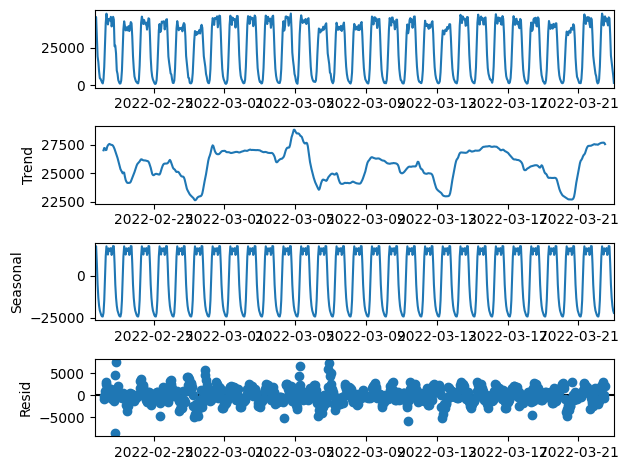

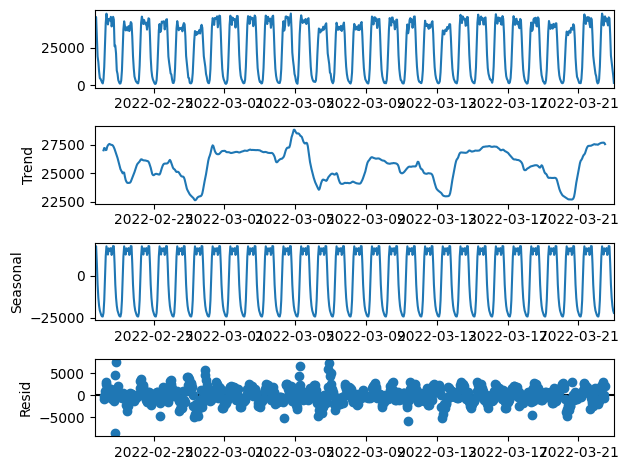

In [25]:
decomposed.plot()

чётко прослеживается сезонность (причём дневная и недельная) доп комментарий - нет , это не недельная сезонность , но у каждого дня есть свой паттерн , с чем он связан установить не удалось 

train + valid = trava

разбиенние на 4 выборки (валидация - 15% от общего объёма , тест - 15% от общего объёма)

In [26]:
y_tra_va, y_test = temporal_train_test_split(data,test_size = 0.15)
y_train, y_valid = temporal_train_test_split(y_tra_va,test_size = 0.176)

In [27]:
print(data.shape)
print(y_train.shape)
print(y_valid.shape)
y_test.shape

(705, 1)
(493, 1)
(106, 1)


(106, 1)

для начала сделаем наивные модели 1) будет давать значение прошлого часа 

In [28]:
forecast_data = y_train.copy()
forecast_data["Past_Value_Forecast"] = forecast_data["counter_data"].shift(1)
forecast_data = forecast_data.iloc[1:]
np.sqrt(mean_squared_error(forecast_data['counter_data'],forecast_data['Past_Value_Forecast']))

6147.837352138654

6100, плохой бэйзлайн

2) будет давать значение в это же время с прошлого дня 

In [29]:
forecast_data = y_train.copy()
forecast_data["Past_Value_Forecast"] = forecast_data["counter_data"].shift(24)
forecast_data = forecast_data.iloc[24:]
np.sqrt(mean_squared_error(forecast_data['counter_data'],forecast_data['Past_Value_Forecast']))

3221.6821820141536

3200 , звучит как то что можно будет Преодоле́ть 

3) будет давать значение в это же время в этот же день недели с прошлой недели 

In [30]:
forecast_data = y_train.copy()
forecast_data["Past_Value_Forecast"] = forecast_data["counter_data"].shift(168)
forecast_data = forecast_data.iloc[168:]
np.sqrt(mean_squared_error(forecast_data['counter_data'],forecast_data['Past_Value_Forecast']))

2904.3307435114266

ожидал что будет лучше , вообщем 2900 наш бэзлайн

<div class="alert alert-info">
<h2> Комментарий выполняющего: <a class="tocSkip"> </h2>
на всякий случай выбор метрики здесь
</div> 

выбор метрики: основные метрики которые мы можем использовать rmse , mae или mape. Смотрите у нас есть по сути два варианта rmse и mape.Что нам важнее? Наверное определить точнее когда нагрузка высокая (как мне кажется) , mae будет завышаться на ночьных сессиях (ошибка в 10ед днём будет иметь куда меньшей процент чем 10ед ночью) тоесть мы можем получить сильное завышение реальной ошибки. RMSE наоборот ночью занижается , но не в десятки раз , тоесть она стабильнее следовательно буду использовать именно rmse 

вывод анализа: у нас есть счётчик какого-то процесса имеющий дневную сезонность где спады и взлёты счётчика происходят примерно в одно и тоже время 
<br>больше аномалий зафиксированно не было 

## Обучение prophet

функция преобразующая данные в формат удобный профету

In [31]:
def hello_prophet(df):
    pr_df = df.reset_index()
    pr_df.columns = ['ds', 'y']
    return pr_df

In [32]:
data_prophet =  hello_prophet(data)
tra_va_prophet = hello_prophet(y_tra_va)
test_prophet = hello_prophet(y_test)
train_prophet = hello_prophet(y_train)
valid_prophet = hello_prophet(y_valid)

обучение профета

In [33]:
prophet_m = Prophet()
prophet_m.fit(train_prophet)

14:09:34 - cmdstanpy - INFO - Chain [1] start processing
14:09:34 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
forecast = prophet_m.predict(valid_prophet)

In [35]:
forecast

ds         trend    yhat_lower    yhat_upper  \
0   2022-03-14 05:00:00  24727.008433   8195.843544  14957.053618   
1   2022-03-14 06:00:00  24720.974204  20604.557230  27325.434392   
2   2022-03-14 07:00:00  24714.939975  30828.775588  37664.699069   
3   2022-03-14 08:00:00  24708.905745  36181.327616  42969.970288   
4   2022-03-14 09:00:00  24702.871516  36814.235227  43774.896999   
..                  ...           ...           ...           ...   
101 2022-03-18 10:00:00  24117.551277  35853.116720  43006.255597   
102 2022-03-18 11:00:00  24111.517048  35975.834262  42774.516539   
103 2022-03-18 12:00:00  24105.482819  36594.584054  43452.154975   
104 2022-03-18 13:00:00  24099.448589  36353.588763  43190.191319   
105 2022-03-18 14:00:00  24093.414360  35793.079040  42752.591866   

      trend_lower   trend_upper  additive_terms  additive_terms_lower  \
0    24727.008433  24727.008433   -13284.392682         -13284.392682   
1    24720.974204  24720.974204     -703.913105           -703.913105   
2    24714.939975  24714.939975     9622.526848           9622.526848   
3    24708.905745  24708.905745    14787.667139          14787.667139   
4    24702.759838  24702.949007    15594.211051          15594.211051   
..            ...           ...             ...                   ...   
101  23996.115234  24258.075569    15294.940692          15294.940692   
102  23988.562769  24254.663137    15263.638057          15263.638057   
103  23980.896200  24251.074106    15779.899273          15779.899273   
104  23972.955073  24246.933417    15743.221983          15743.221983   
105  23964.587450  24242.885535    15042.862970          15042.862970   

     additive_terms_upper         daily   daily_lower   daily_upper  \
0           -13284.392682 -12751.437995 -12751.437995 -12751.437995   
1             -703.913105   -306.743215   -306.743215   -306.743215   
2             9622.526848   9888.087333   9888.087333   9888.087333   
3            14787.667139  14926.863734  14926.863734  14926.863734   
4            15594.211051  15613.275596  15613.275596  15613.275596   
..                    ...           ...           ...           ...   
101          15294.940692  14857.377932  14857.377932  14857.377932   
102          15263.638057  14745.950659  14745.950659  14745.950659   
103          15779.899273  15181.471258  15181.471258  15181.471258   
104          15743.221983  15064.551836  15064.551836  15064.551836   
105          15042.862970  14285.586203  14285.586203  14285.586203   

         weekly  weekly_lower  weekly_upper  multiplicative_terms  \
0   -532.954687   -532.954687   -532.954687                   0.0   
1   -397.169890   -397.169890   -397.169890                   0.0   
2   -265.560485   -265.560485   -265.560485                   0.0   
3   -139.196595   -139.196595   -139.196595                   0.0   
4    -19.064545    -19.064545    -19.064545                   0.0   
..          ...           ...           ...                   ...   
101  437.562760    437.562760    437.562760                   0.0   
102  517.687398    517.687398    517.687398                   0.0   
103  598.428015    598.428015    598.428015                   0.0   
104  678.670147    678.670147    678.670147                   0.0   
105  757.276767    757.276767    757.276767                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                           0.0                         0.0  11442.615751  
1                           0.0                         0.0  24017.061099  
2                           0.0                         0.0  34337.466823  
3                           0.0                         0.0  39496.572884  
4                           0.0                         0.0  40297.082567  
..                          ...                         ...           ...  
101                         0.0                         0.0  39412.491969  
102                      

создание табличке в которой указано истинное и предугаданное значение

In [36]:
data_result = forecast[['ds','yhat']]
data_result['y'] = valid_prophet['y'].copy()
data_result = data_result.set_index(['ds'])
data_result

C:\Users\Алексей\AppData\Local\Temp\ipykernel_8772\1154026111.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



yhat             y
ds                                             
2022-03-14 05:00:00  11442.615751  11145.998000
2022-03-14 06:00:00  24017.061099  24871.138667
2022-03-14 07:00:00  34337.466823  39697.814666
2022-03-14 08:00:00  39496.572884  46679.943333
2022-03-14 09:00:00  40297.082567  44757.724667
...                           ...           ...
2022-03-18 10:00:00  39412.491969  36913.975000
2022-03-18 11:00:00  39375.155105  43621.235667
2022-03-18 12:00:00  39885.382092  44376.084333
2022-03-18 13:00:00  39842.670572  41484.943666
2022-03-18 14:00:00  39136.277330  44743.147000

[106 rows x 2 columns]

визуализация

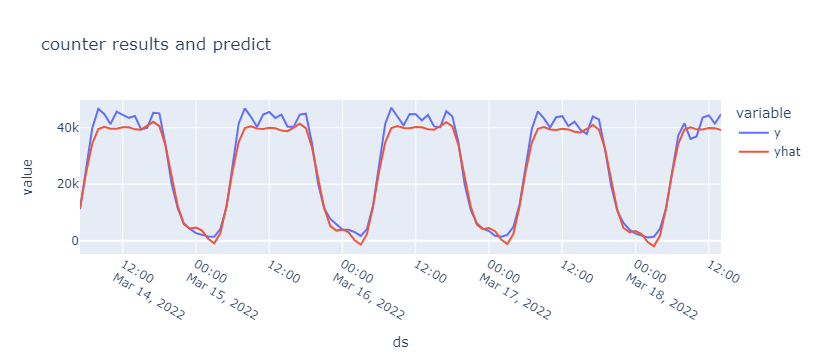

In [37]:
fig = px.line(data_result, x=data_result.index, y=['y','yhat'], title='counter results and predict')
fig.show()

In [38]:
np.sqrt(mean_squared_error(data_result['y'],data_result['yhat']))

3203.7241088093383

хуже baseline , нужно оптимизировать параметры

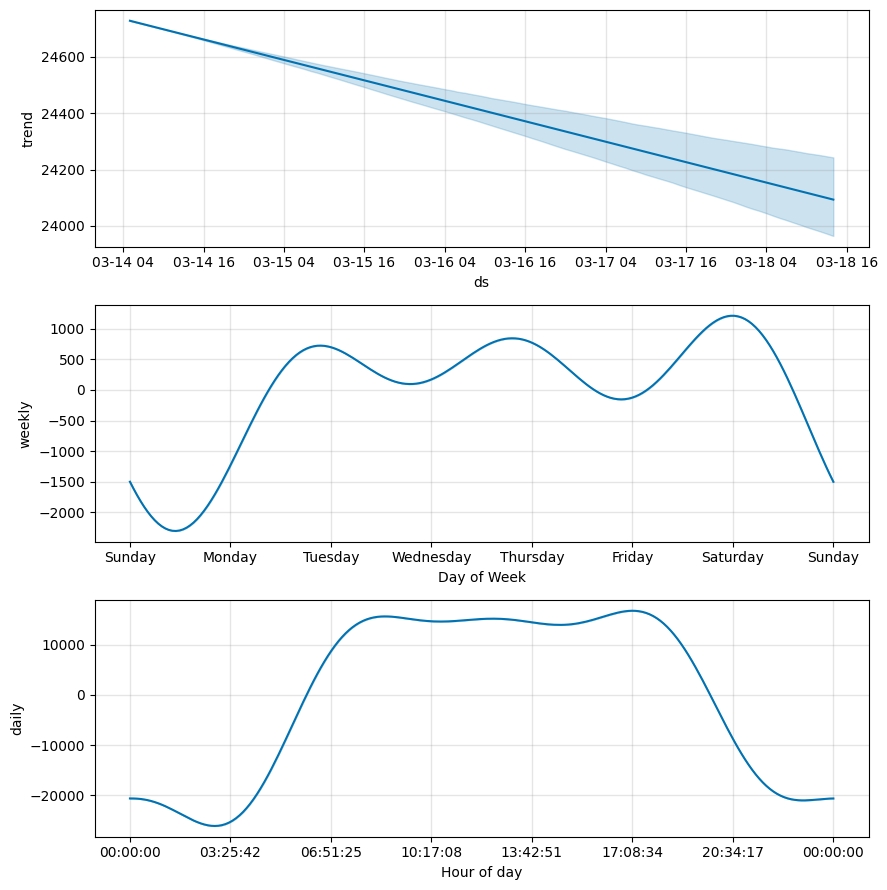

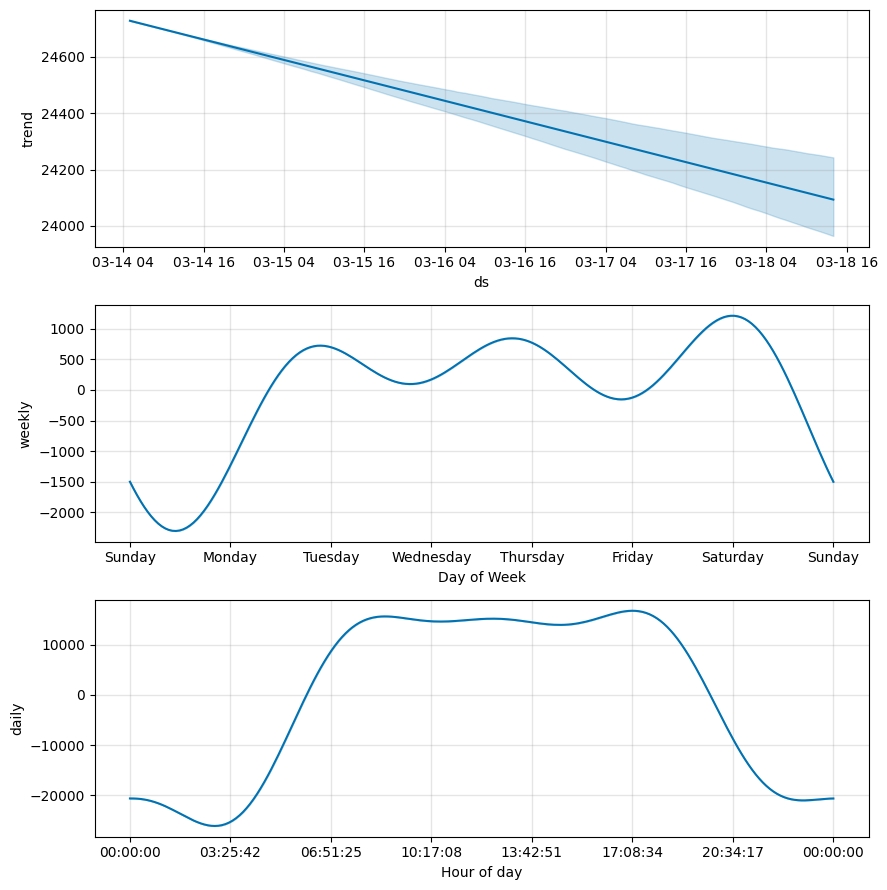

In [39]:
prophet_m.plot_components(forecast)

оно видит лёгкий трэнд , окей

а теперь кроссвалидация с подбором гипер параметров 

In [40]:
%%time
param_grid = {  
    'changepoint_prior_scale': np.linspace(0.001, 0.5, 5),
    'seasonality_prior_scale': np.linspace(0.01, 10.0, 5),
    'daily_seasonality': [24],
    'seasonality_mode': ['multiplicative']
}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Use cross validation to evaluate all parameters
def get_cv_validation_result(all_params):
    i = 0
    tuning_results = pd.DataFrame()
    for params in all_params:
        m = Prophet(changepoint_prior_scale = params['changepoint_prior_scale'],
                    seasonality_prior_scale = params['seasonality_prior_scale'],
                    daily_seasonality = params['daily_seasonality'],
                    seasonality_mode = params['seasonality_mode']).fit(tra_va_prophet)
        df_cv = cross_validation(m, initial='7 days', period='7 days', horizon = '1 days', parallel="processes")
        # проверить результат по сравнению с использованием и без диапазона initial days
        
        df_p = performance_metrics(df_cv, rolling_window=1)
        print('Params:\n', params, '\n')
        print('Result:\n', df_p, '\n')
        # Объединяем результаты с набором параметров
        result = df_p.drop(columns=['horizon']).set_index(pd.Index([i]))
        result = result.join(pd.DataFrame(params, index=[i]))
        tuning_results = tuning_results.append(result)
        i += 1
    return tuning_results
tuning_results = get_cv_validation_result(all_params)

14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] done processing
14:09:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:36 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:09:40 - cmdstanpy - INFO - Chain [1] start processing
14:09:40 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse          rmse          mae      mape     mdape  \
0  1 days  2.365017e+08  15378.611191  14060.19298  3.246838  0.336193   

      smape  coverage  
0  0.716348  0.736111   



14:09:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:09:40 - cmdstanpy - INFO - Chain [1] start processing
14:09:41 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:09:44 - cmdstanpy - INFO - Chain [1] start processing
14:09:44 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 2.5075, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  4.002880e+06  2000.719798  1407.046226  0.116438  0.060395   

      smape  coverage  
0  0.103547  0.888889   



14:09:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:09:44 - cmdstanpy - INFO - Chain [1] start processing
14:09:45 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:09:48 - cmdstanpy - INFO - Chain [1] start processing
14:09:48 - cmdstanpy - INFO - Chain [1] done processing
14:09:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.005, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  4.037171e+06  2009.271268  1415.206412  0.118358  0.060524   

      smape  coverage  
0  0.104776     0.875   



14:09:48 - cmdstanpy - INFO - Chain [1] start processing
14:09:49 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:09:52 - cmdstanpy - INFO - Chain [1] start processing
14:09:52 - cmdstanpy - INFO - Chain [1] done processing
14:09:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 7.5024999999999995, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  4.048592e+06  2012.111282  1415.333837  0.117424  0.060076   

      smape  coverage  
0  0.103951     0.875   



14:09:52 - cmdstanpy - INFO - Chain [1] start processing
14:09:53 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:09:55 - cmdstanpy - INFO - Chain [1] start processing
14:09:55 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape    mdape  \
0  1 days  4.045330e+06  2011.300663  1414.920995  0.117345  0.05849   

      smape  coverage  
0  0.103839     0.875   



<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:09:57 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 0.01, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse          rmse           mae      mape     mdape  \
0  1 days  2.373299e+08  15405.516481  14034.002143  3.275579  0.338471   

      smape  coverage  
0  0.714191  0.722222   



14:09:57 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:09:59 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 2.5075, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.247301e+07  3531.714912  2512.124769  0.158674  0.113056   

      smape  coverage  
0  0.177816  0.597222   



14:10:00 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:02 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 5.005, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape    mdape  \
0  1 days  1.285570e+07  3585.484695  2556.646643  0.156128  0.11642   

      smape  coverage  
0  0.169639  0.597222   



14:10:02 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:04 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 7.5024999999999995, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.257345e+07  3545.905495  2537.272779  0.159165  0.116041   

      smape  coverage  
0  0.174683  0.597222   



14:10:04 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:07 - cmdstanpy - INFO - Chain [1] start processing
14:10:07 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 10.0, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.268842e+07  3562.080389  2539.900163  0.156717  0.115921   

      smape  coverage  
0  0.171599  0.611111   



<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:08 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 0.01, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse          rmse           mae      mape     mdape  \
0  1 days  2.364273e+08  15376.193075  14064.674393  3.242406  0.335218   

      smape  coverage  
0  0.716723  0.736111   



14:10:09 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:11 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 2.5075, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape    mdape  \
0  1 days  1.308060e+07  3616.710617  2598.436593  0.153432  0.11535   

      smape  coverage  
0  0.160711  0.638889   



14:10:11 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:13 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 5.005, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae     mape     mdape  \
0  1 days  1.341460e+07  3662.594035  2634.532802  0.15449  0.116897   

      smape  coverage  
0  0.161415     0.625   



14:10:14 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:16 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 7.5024999999999995, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae     mape     mdape  \
0  1 days  1.332536e+07  3650.391809  2618.991477  0.15338  0.115164   

      smape  coverage  
0  0.160017  0.638889   



14:10:16 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:18 - cmdstanpy - INFO - Chain [1] start processing
14:10:18 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 10.0, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse        mae      mape     mdape    smape  \
0  1 days  1.326307e+07  3641.849474  2616.9225  0.155896  0.115859  0.16497   

   coverage  
0  0.652778   



<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:20 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.37525, 'seasonality_prior_scale': 0.01, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse          rmse          mae      mape     mdape  \
0  1 days  2.365843e+08  15381.297621  14040.58444  3.256652  0.337576   

      smape  coverage  
0  0.715345  0.722222   



14:10:20 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:22 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.37525, 'seasonality_prior_scale': 2.5075, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae     mape     mdape  \
0  1 days  1.356501e+07  3683.070261  2652.398864  0.15156  0.115044   

      smape  coverage  
0  0.155945  0.638889   



14:10:23 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:25 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.37525, 'seasonality_prior_scale': 5.005, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.356048e+07  3682.455995  2662.060282  0.151588  0.116294   

      smape  coverage  
0  0.155087  0.680556   



14:10:25 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:27 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.37525, 'seasonality_prior_scale': 7.5024999999999995, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.364685e+07  3694.164059  2669.576075  0.151439  0.116353   

      smape  coverage  
0  0.154881  0.666667   



14:10:27 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:29 - cmdstanpy - INFO - Chain [1] start processing
14:10:29 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.37525, 'seasonality_prior_scale': 10.0, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.370025e+07  3701.384601  2678.920727  0.151798  0.115635   

      smape  coverage  
0  0.155383  0.666667   



<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:31 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse          rmse           mae      mape     mdape  \
0  1 days  2.372539e+08  15403.048014  13989.712959  3.288651  0.336427   

      smape  coverage  
0  0.712381  0.722222   



14:10:31 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:33 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 2.5075, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.350870e+07  3675.417948  2666.868546  0.152339  0.112552   

      smape  coverage  
0  0.156485  0.680556   



14:10:34 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:36 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.005, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.344808e+07  3667.162091  2655.546269  0.150439  0.114832   

      smape  coverage  
0  0.154068  0.694444   



14:10:36 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

14:10:38 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7.5024999999999995, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.355527e+07  3681.748328  2664.197412  0.150324  0.114892   

      smape  coverage  
0  0.154017  0.708333   



14:10:38 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon           mse         rmse          mae      mape     mdape  \
0  1 days  1.360732e+07  3688.810035  2667.637982  0.149913  0.113545   

      smape  coverage  
0  0.153598  0.666667   

CPU times: total: 4.41 s
Wall time: 1min 5s


<timed exec>:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [41]:
tuning_results

mse          rmse           mae      mape     mdape     smape  \
0   2.365017e+08  15378.611191  14060.192980  3.246838  0.336193  0.716348   
1   4.002880e+06   2000.719798   1407.046226  0.116438  0.060395  0.103547   
2   4.037171e+06   2009.271268   1415.206412  0.118358  0.060524  0.104776   
3   4.048592e+06   2012.111282   1415.333837  0.117424  0.060076  0.103951   
4   4.045330e+06   2011.300663   1414.920995  0.117345  0.058490  0.103839   
5   2.373299e+08  15405.516481  14034.002143  3.275579  0.338471  0.714191   
6   1.247301e+07   3531.714912   2512.124769  0.158674  0.113056  0.177816   
7   1.285570e+07   3585.484695   2556.646643  0.156128  0.116420  0.169639   
8   1.257345e+07   3545.905495   2537.272779  0.159165  0.116041  0.174683   
9   1.268842e+07   3562.080389   2539.900163  0.156717  0.115921  0.171599   
10  2.364273e+08  15376.193075  14064.674393  3.242406  0.335218  0.716723   
11  1.308060e+07   3616.710617   2598.436593  0.153432  0.115350  0.160711   
12  1.341460e+07   3662.594035   2634.532802  0.154490  0.116897  0.161415   
13  1.332536e+07   3650.391809   2618.991477  0.153380  0.115164  0.160017   
14  1.326307e+07   3641.849474   2616.922500  0.155896  0.115859  0.164970   
15  2.365843e+08  15381.297621  14040.584440  3.256652  0.337576  0.715345   
16  1.356501e+07   3683.070261   2652.398864  0.151560  0.115044  0.155945   
17  1.356048e+07   3682.455995   2662.060282  0.151588  0.116294  0.155087   
18  1.364685e+07   3694.164059   2669.576075  0.151439  0.116353  0.154881   
19  1.370025e+07   3701.384601   2678.920727  0.151798  0.115635  0.155383   
20  2.372539e+08  15403.048014  13989.712959  3.288651  0.336427  0.712381   
21  1.350870e+07   3675.417948   2666.868546  0.152339  0.112552  0.156485   
22  1.344808e+07   3667.162091   2655.546269  0.150439  0.114832  0.154068   
23  1.355527e+07   3681.748328   2664.197412  0.150324  0.114892  0.154017   
24  1.360732e+07   3688.810035   2667.637982  0.149913  0.113545  0.153598   

    coverage  changepoint_prior_scale  seasonality_prior_scale  \
0   0.736111                  0.00100                   0.0100   
1   0.888889                  0.00100                   2.5075   
2   0.875000                  0.00100                   5.0050   
3   0.875000                  0.00100                   7.5025   
4   0.875000                  0.00100                  10.0000   
5   0.722222                  0.12575                   0.0100   
6   0.597222                  0.12575                   2.5075   
7   0.597222                  0.12575                   5.0050   
8   0.597222                  0.12575                   7.5025   
9   0.611111                  0.12575                  10.0000   
10  0.736111                  0.25050                   0.0100   
11  0.638889                  0.25050                   2.5075   
12  0.625000                  0.25050                   5.0050   
13  0.638889                  0.25050                   7.5025   
14  0.652778                  0.25050                  10.0000   
15  0.722222                  0.37525                   0.0100   
16  0.638889                  0.37525                   2.5075   
17  0.680556                  0.37525                   5.0050   
18  0.666667                  0.37525                   7.5025   
19  0.666667                  0.37525                  10.0000   
20  0.722222                  0.50000                   0.0100   
21  0.680556                  0.50000                   2.5075   
22  0.694444                  0.50000                   5.0050   
23  0.708333                  0.50000                   7.5025   
24  0.666667                  0.50000                  10.0000   

    daily_seasonality seasonality_mode  
0                  24   multiplicative  
1                  24   multiplicative  
2                  24   multiplicative  
3                  24   multiplicative  
4                  24   multiplicative  
5                  24

In [42]:
best_params = all_params[np.argmin(tuning_results['rmse'])]
print('Минимальное RMSE = ', tuning_results.loc[np.argmin(tuning_results['rmse'])].rmse,'\n')
print('Параметры лучшей модели:', best_params)

Минимальное RMSE =  2000.7197976190052 

Параметры лучшей модели: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 2.5075, 'daily_seasonality': 24, 'seasonality_mode': 'multiplicative'}


окей уже лучше , преодалели baseline

In [43]:
best_model = Prophet(**best_params)

посмторим как в целом выглядит предикт и как модель работает с сезонностью

14:10:40 - cmdstanpy - INFO - Chain [1] start processing
14:10:40 - cmdstanpy - INFO - Chain [1] done processing
14:10:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:10:40 - cmdstanpy - INFO - Chain [1] start processing
14:10:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Алексей\AppData\Local\Temp\ipykernel_8772\3113117342.py:6: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\Алексей\AppData\Local\Temp\ipykernel_8772\3113117342.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



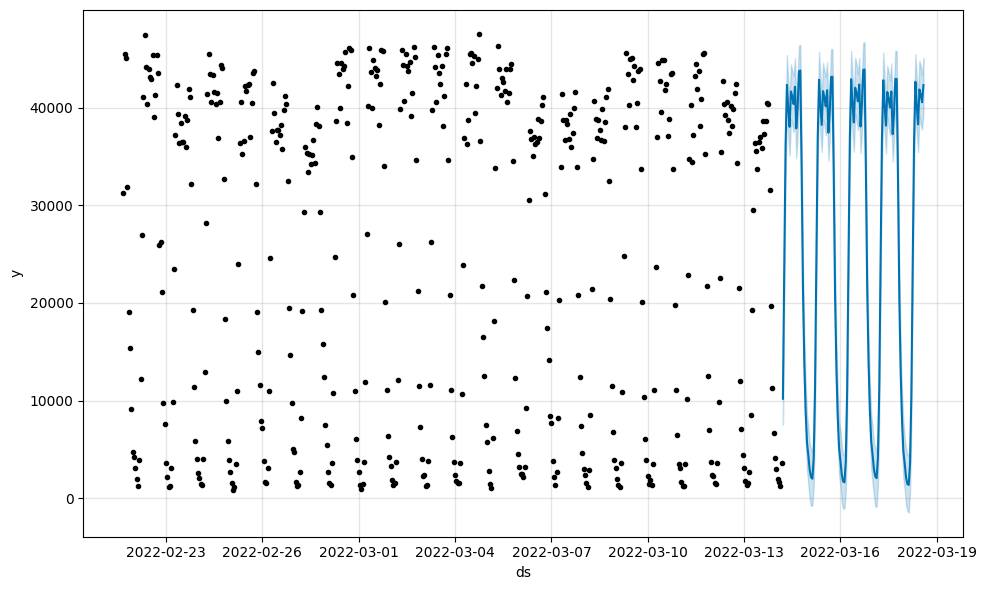

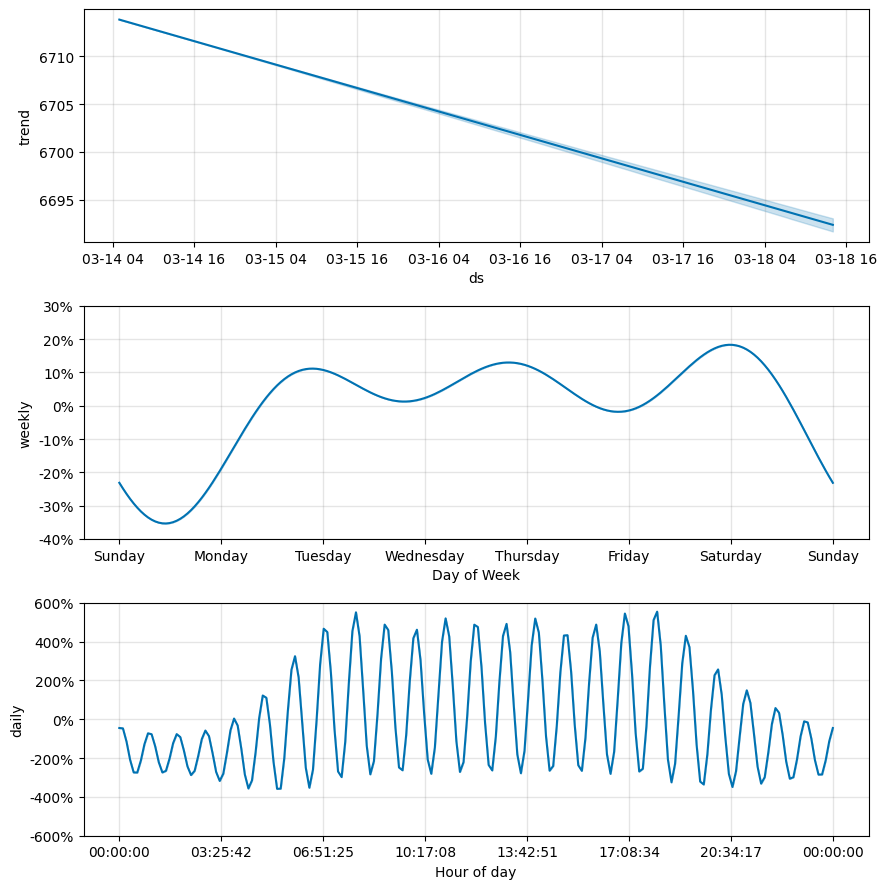

In [44]:
best_model.fit(train_prophet)
forecast = best_model.predict(valid_prophet[['ds']])
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(valid_prophet.set_index('ds'))
plot1 = best_model.plot(forecast)
plot2 = best_model.plot_components(forecast)
plot1.show()
plot2.show()

хм , вроде негативно не влияет на результат , но график часовой довольно сильно колбасит 

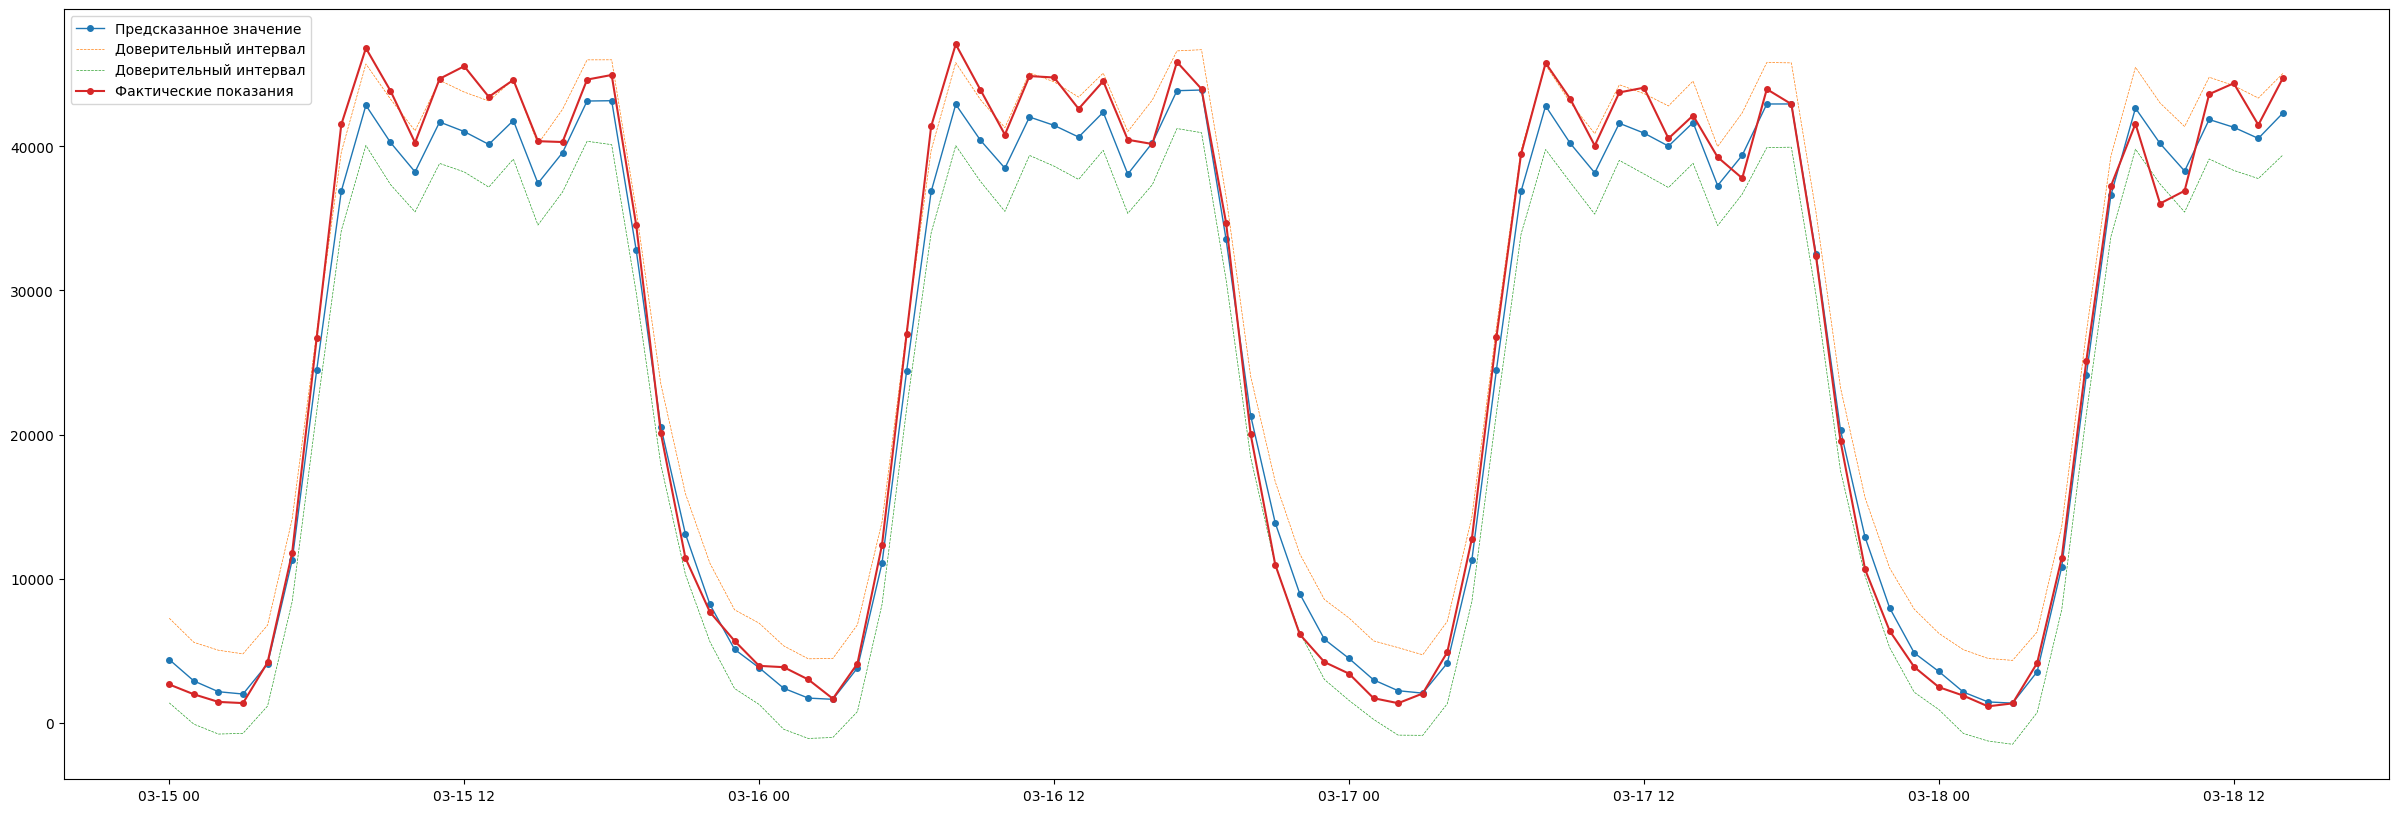

In [45]:
start, end = '2022-03-15 0:00', '2022-03-19 23:50'
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)
ax.plot(cmp_df['yhat'].loc[start:end], marker='.', linestyle='-', markersize=8, linewidth=1, label='Предсказанное значение')
ax.plot(cmp_df[['yhat_upper','yhat_lower']].loc[start:end], linestyle='--', linewidth=0.5, label='Доверительный интервал')
ax.plot(cmp_df.loc[start:end].y , marker='o', markersize=4, linestyle='-', label='Фактические показания')
ax.legend();

In [46]:
np.sqrt(mean_squared_error(cmp_df['y'],cmp_df['yhat']))

2185.709807520845

такое ощущение что модель занижает , проверим это

In [47]:
def mean_percentage_error(actual, forecast):
    """
    Calculate Mean Percentage Error (MPE).

    Parameters:
        actual (list or array): The actual values of the time series.
        forecast (list or array): The forecasted values of the time series.

    Returns:
        float: The Mean Percentage Error (MPE) value.
    """
    if len(actual) != len(forecast):
        raise ValueError("Length of actual and forecast must be the same.")

    total_percentage_error = 0
    for i in range(len(actual)):
        if actual[i] != 0:  # Avoid division by zero
            percentage_error = (actual[i] - forecast[i]) / actual[i]
            total_percentage_error += percentage_error

    mpe = (total_percentage_error / len(actual)) * 100
    return mpe

In [48]:
mpe_value = mean_percentage_error(cmp_df['y'],cmp_df['yhat'])
print("Mean Percentage Error (MPE):", mpe_value)

Mean Percentage Error (MPE): -2.786428945403521


угу занижает , честно говоря не знаю как можно это исправить , но детекция была произведена 

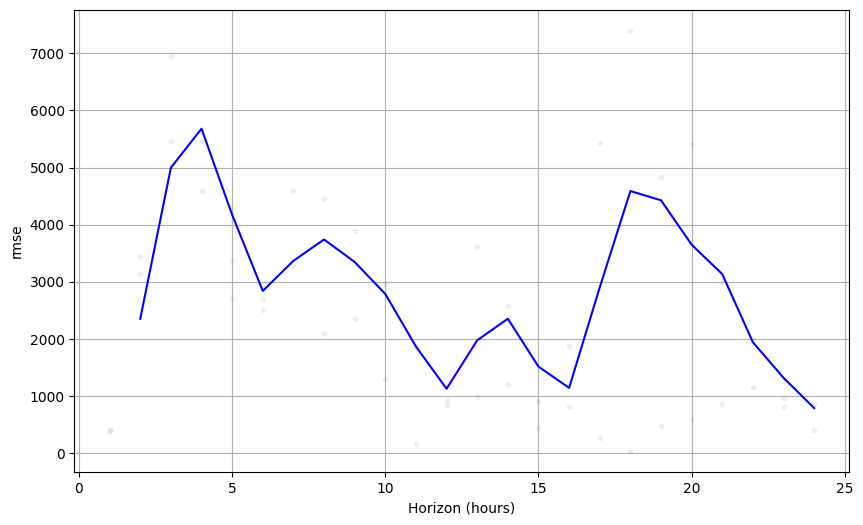

In [49]:
df_cv = cross_validation(best_model, initial='7 days', period='7 days', horizon = '1 days', parallel="processes")
fig1 = plot_cross_validation_metric(df_cv, metric='rmse')

самая большая ошибка там где происходят изменения счётчика довольно сильные

вывод по prothet : модель имеет свои недостатки , ей свойственно занижать результат , но baseline преодолела , давайте рассмотрим ещё пару различных подходов

## Обучение rnn

вступление : данных для обучения rnn очень мало , поэтому возможно покажет значение хуже профета

копируем , для дальнейшего преобразования

In [50]:
rnn_data = data
rnn_data

counter_data
counter_timestamp                
2022-02-21 16:00:00  31271.630001
2022-02-21 17:00:00  45465.502000
2022-02-21 18:00:00  45091.751334
2022-02-21 19:00:00  31916.051666
2022-02-21 20:00:00  19101.347001
...                           ...
2022-03-22 20:00:00  19620.574334
2022-03-22 21:00:00  15462.083333
2022-03-22 22:00:00  11133.987069
2022-03-22 23:00:00   6881.049907
2022-03-23 00:00:00   1618.347667

[705 rows x 1 columns]

сделаем функцию которая добавляет следующие фичи: час,день недели , скользящее среднее , и какие показатели были за 1-4 суток до этого  
<br> важный нюанс в rnn мы будем подавать только показатели значений за 1-4 суток до этого , остальное нужно для catboost

In [51]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(24, max_lag + 1):
        data['lag_{}'.format(lag)] = data['counter_data'].shift(lag)
    data['rolling_mean'] = data['lag_24'].rolling(rolling_mean_size).mean()

make_features(data, 96, 5)

In [52]:
data = data.dropna()

In [53]:
data

counter_data  hour  dayofweek        lag_24  \
counter_timestamp                                                  
2022-02-25 16:00:00  40480.320333    16          4  40611.544000   
2022-02-25 17:00:00  43515.934999    17          4  44379.223333   
2022-02-25 18:00:00  43783.852000    18          4  44041.429667   
2022-02-25 19:00:00  32130.568667    19          4  32656.306667   
2022-02-25 20:00:00  19087.255667    20          4  18373.369667   
...                           ...   ...        ...           ...   
2022-03-22 20:00:00  19620.574334    20          1  19698.491999   
2022-03-22 21:00:00  15462.083333    21          1  15138.260000   
2022-03-22 22:00:00  11133.987069    22          1  11277.455334   
2022-03-22 23:00:00   6881.049907    23          1   7740.329333   
2022-03-23 00:00:00   1618.347667     0          2   6063.174790   

                           lag_25        lag_26        lag_27        lag_28  \
counter_timestamp                                                             
2022-02-25 16:00:00  36898.569667  41524.386000  40395.365333  41628.574667   
2022-02-25 17:00:00  40611.544000  36898.569667  41524.386000  40395.365333   
2022-02-25 18:00:00  44379.223333  40611.544000  36898.569667  41524.386000   
2022-02-25 19:00:00  44041.429667  44379.223333  40611.544000  36898.569667   
2022-02-25 20:00:00  32656.306667  44041.429667  44379.223333  40611.544000   
...                           ...           ...           ...           ...   
2022-03-22 20:00:00  32903.677333  43654.449333  44488.716333  38442.651334   
2022-03-22 21:00:00  19698.491999  32903.677333  43654.449333  44488.716333   
2022-03-22 22:00:00  15138.260000  19698.491999  32903.677333  43654.449333   
2022-03-22 23:00:00  11277.455334  15138.260000  19698.491999  32903.677333   
2022-03-23 00:00:00   7740.329333  11277.455334  15138.260000  19698.491999   

                           lag_29        lag_30  ...        lag_88  \
counter_timestamp                                ...                 
2022-02-25 16:00:00  43300.895667  40555.862999  ...   4250.166333   
2022-02-25 17:00:00  41628.574667  43300.895667  ...   3112.549000   
2022-02-25 18:00:00  40395.365333  41628.574667  ...   1937.366333   
2022-02-25 19:00:00  41524.386000  40395.365333  ...   1261.371666   
2022-02-25 20:00:00  36898.569667  41524.386000  ...   3924.515666   
...                           ...           ...  ...           ...   
2022-03-22 20:00:00  40564.140666  45037.947666  ...   3500.006000   
2022-03-22 21:00:00  38442.651334  40564.140666  ...  10097.217001   
2022-03-22 22:00:00  44488.716333  38442.651334  ...  23265.182666   
2022-03-22 23:00:00  43654.449333  44488.716333  ...  35663.914999   
2022-03-23 00:00:00  32903.677333  43654.449333  ...  42593.398000   

                           lag_89        lag_90        lag_91        lag_92  \
counter_timestamp                                                             
2022-02-25 16:00:00   4704.634667   9179.332000  15408.110667  19101.347001   
2022-02-25 17:00:00   4250.166333   4704.634667   9179.332000  15408.110667   
2022-02-25 18:00:00   3112.549000   4250.166333   4704.634667   9179.332000   
2022-02-25 19:00:00   1937.366333   3112.549000   4250.166333   4704.634667   
2022-02-25 20:00:00   1261.371666   1937.366333   3112.549000   4250.166333   
...                           ...           ...           ...           ...   
2022-03-22 20:00:00   1296.752000   1059.594666   2202.621666   2605.529333   
2022-03-22 21:00:00   3500.006000   1296.752000   1059.594666   2202.621666   
2022-03-22 22:00:00  10097.217001   3500.006000   1296.752000   1059.594666   
2022-03-22 23:00:00  23265.182666  10097.217001   3500.006000   1296.752000   
2022-03-23 00:00:00  35663.914999  23265.182666  10097.217001   3500.006000   

                           lag_93        lag_94        lag_95        lag_96  \
counter_timestamp                                                             
2022-02-25 

выбираем столбцы для обучения и таргет

In [54]:
rnn_x = data.filter(like="lag").columns 
rnn_y = data.filter(like="counter_data").columns

ещё раз делим данные , важный нюанс на валидации и тесте количество данных не должно поменяться

In [55]:
tra_va, test = temporal_train_test_split(data,test_size = 0.174)
train, valid = temporal_train_test_split(tra_va,test_size = 0.21)

In [56]:
print(data.shape)
print(train.shape)
print(valid.shape)
test.shape

(609, 77)
(397, 77)
(106, 77)


(106, 77)

производим стандартизацию (это надо только для нейронок) доп комментарий , я здесь затупил , можно было обойтись 1 StandardScaler

In [57]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()
scaled_train_x = scaler_x.fit_transform(train[rnn_x])
scaled_valid_x = scaler_x.transform(valid[rnn_x])
scaled_test_x = scaler_x.transform(test[rnn_x])
scaled_train_y = scaler_y.fit_transform(train[rnn_y])
scaled_valid_y = scaler_y.transform(valid[rnn_y])
scaled_test_y = scaler_y.transform(test[rnn_y])

очень жаль что 4 недели всего данных( было бы больше данных , можно было бы взять и запихнуть период в неделю , а так придётся использовать 3 дня (чтобы не отбрасывать 25% данных из обучения)

а теперь само построение нейронки будем использовать 2 слоя LSTM

In [58]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(73, 1),return_sequences = True))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(0.001), loss='mse')

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 73, 200)           161600    
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________


установим пару полезных фич валидация и ранняя остановка

In [60]:
earlystop_callb = EarlyStopping(monitor='val_loss',
                                patience=50,
                                )
checkpoint_callb = ModelCheckpoint(filepath='model_targ0.h5',
                                   monitor='val_loss',
                                   save_best_only=True)

reducelr_callb = ReduceLROnPlateau(monitor = 'val_loss', 
                                   factor=0.1,
                                   patience=30,
                                   verbose=1)

In [61]:
model.fit(scaled_train_x,scaled_train_y,epochs=1000,validation_data=(scaled_valid_x, scaled_valid_y),batch_size=7, 
                                         callbacks=[reducelr_callb,
                                                    checkpoint_callb,
                                                    earlystop_callb
                                         ])

Epoch 1/1000
57/57 [==============================] - 4s 42ms/step - loss: 4523282944.0000 - val_loss: 0.9862 - lr: 0.0010
Epoch 2/1000
57/57 [==============================] - 2s 38ms/step - loss: 0.8802 - val_loss: 0.9836 - lr: 0.0010
Epoch 3/1000
57/57 [==============================] - 2s 38ms/step - loss: 0.8725 - val_loss: 0.9723 - lr: 0.0010
Epoch 4/1000
57/57 [==============================] - 2s 38ms/step - loss: 0.7997 - val_loss: 0.6545 - lr: 0.0010
Epoch 5/1000
57/57 [==============================] - 2s 39ms/step - loss: 0.5941 - val_loss: 0.6186 - lr: 0.0010
Epoch 6/1000
57/57 [==============================] - 2s 38ms/step - loss: 1.1322 - val_loss: 0.8654 - lr: 0.0010
Epoch 7/1000
57/57 [==============================] - 2s 38ms/step - loss: 0.6697 - val_loss: 0.6802 - lr: 0.0010
Epoch 8/1000
57/57 [==============================] - 2s 38ms/step - loss: 0.5807 - val_loss: 0.7690 - lr: 0.0010
Epoch 9/1000
57/57 [==============================] - 2s 37ms/step - loss: 0.65

In [62]:
model_best_rnn = load_model('model_targ0.h5')

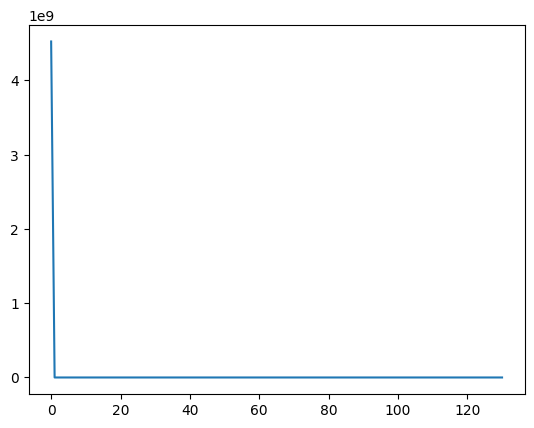

In [63]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [64]:
pr = model_best_rnn.predict(scaled_valid_x)

4/4 [==============================] - 0s 19ms/step


In [65]:
true_predictions = scaler_y.inverse_transform(pr)

In [66]:
np.sqrt(mean_squared_error(valid[rnn_y],true_predictions))

2181.8889263681917

минимальное значение 1966 на валидации удалось получить , лучше чем профет (эту модельку я сохранил)

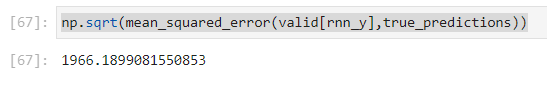

In [67]:
plot_data = valid[rnn_y]

In [68]:
plot_data['pred'] = true_predictions

C:\Users\Алексей\AppData\Local\Temp\ipykernel_8772\4250020881.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [69]:
plot_data

counter_data          pred
counter_timestamp                              
2022-03-14 05:00:00  11145.998000  11029.192383
2022-03-14 06:00:00  24871.138667  25518.878906
2022-03-14 07:00:00  39697.814666  37959.054688
2022-03-14 08:00:00  46679.943333  44228.972656
2022-03-14 09:00:00  44757.724667  45568.324219
...                           ...           ...
2022-03-18 10:00:00  36913.975000  43537.472656
2022-03-18 11:00:00  43621.235667  43448.066406
2022-03-18 12:00:00  44376.084333  42501.121094
2022-03-18 13:00:00  41484.943666  41609.703125
2022-03-18 14:00:00  44743.147000  40942.925781

[106 rows x 2 columns]

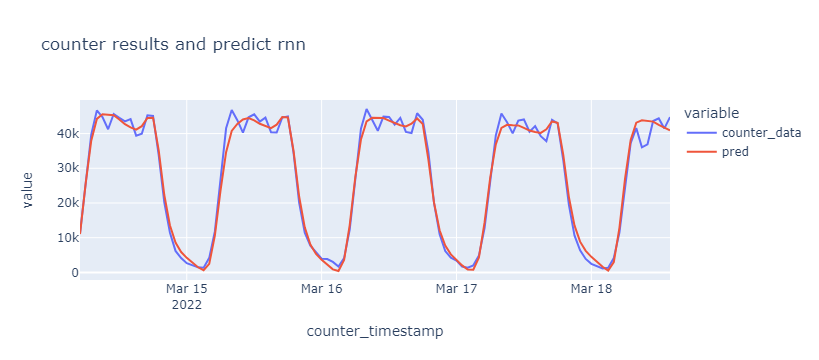

In [70]:
fig = px.line(plot_data, x=plot_data.index, y=['counter_data','pred'], title='counter results and predict rnn')
fig.show()

вот график самих предиктов и истинного значения , здесь не занижает , но надо поиграться со структурой как мне кажется

## Обучение CatBoost

последний подход catboost

In [71]:
tra_va[['counter_data']]

counter_data
counter_timestamp                
2022-02-25 16:00:00  40480.320333
2022-02-25 17:00:00  43515.934999
2022-02-25 18:00:00  43783.852000
2022-02-25 19:00:00  32130.568667
2022-02-25 20:00:00  19087.255667
...                           ...
2022-03-18 10:00:00  36913.975000
2022-03-18 11:00:00  43621.235667
2022-03-18 12:00:00  44376.084333
2022-03-18 13:00:00  41484.943666
2022-03-18 14:00:00  44743.147000

[503 rows x 1 columns]

будем использовать все фичи которые сгенерировали раннее 

In [72]:
cb_model = CatBoostRegressor(max_depth=8, iterations=1000,
                             early_stopping_rounds=20,
                             objective="RMSE",
                             learning_rate = 0.01,
                             verbose=10,
                             random_state=1)

cb_model.fit(train.drop("counter_data",axis = 1), train[['counter_data']], eval_set=(valid.drop("counter_data",axis = 1), valid[['counter_data']]))

0:	learn: 16681.3160846	test: 17484.5417695	best: 17484.5417695 (0)	total: 162ms	remaining: 2m 41s
10:	learn: 15389.7756438	test: 16216.6326660	best: 16216.6326660 (10)	total: 341ms	remaining: 30.7s
20:	learn: 14188.7041255	test: 15037.3939905	best: 15037.3939905 (20)	total: 537ms	remaining: 25.1s
30:	learn: 13093.0999582	test: 13945.4450923	best: 13945.4450923 (30)	total: 718ms	remaining: 22.5s
40:	learn: 12088.6911073	test: 12941.0258613	best: 12941.0258613 (40)	total: 903ms	remaining: 21.1s
50:	learn: 11160.8546741	test: 12024.9802015	best: 12024.9802015 (50)	total: 1.08s	remaining: 20.2s
60:	learn: 10327.3041562	test: 11190.0537658	best: 11190.0537658 (60)	total: 1.27s	remaining: 19.6s
70:	learn: 9545.3611895	test: 10409.8741435	best: 10409.8741435 (70)	total: 1.45s	remaining: 19s
80:	learn: 8822.3570779	test: 9691.2965842	best: 9691.2965842 (80)	total: 1.64s	remaining: 18.6s
90:	learn: 8178.1662130	test: 9050.8878714	best: 9050.8878714 (90)	total: 1.82s	remaining: 18.2s
100:	learn

In [73]:
pr = cb_model.predict(valid.drop("counter_data",axis = 1))

In [74]:
plot_data['pred'] = pr

C:\Users\Алексей\AppData\Local\Temp\ipykernel_8772\2168426009.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



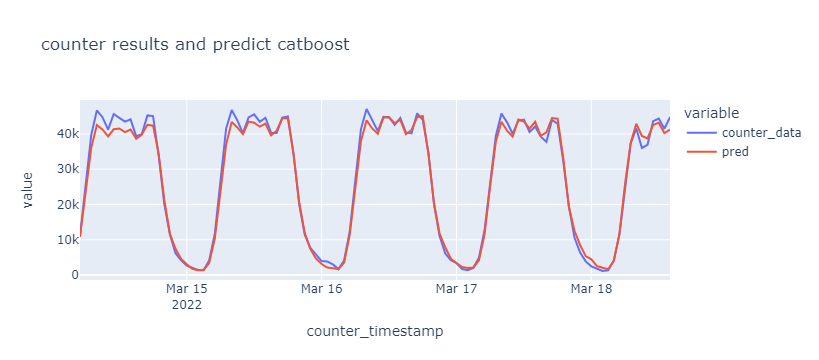

In [75]:
fig = px.line(plot_data, x=plot_data.index, y=['counter_data','pred'], title='counter results and predict catboost')
fig.show()

лучшая валидация 1700 , получается лучший подход? ну-ка взляним на что опирается модель

## Интерпретация CatBoostRegressor

In [76]:
import shap
shap.initjs()

добавляем предикт к основным столбцам

In [77]:
tra_va['y_pred'] = cb_model.predict(tra_va.drop("counter_data",axis = 1))

In [78]:
tra_va

counter_data  hour  dayofweek        lag_24  \
counter_timestamp                                                  
2022-02-25 16:00:00  40480.320333    16          4  40611.544000   
2022-02-25 17:00:00  43515.934999    17          4  44379.223333   
2022-02-25 18:00:00  43783.852000    18          4  44041.429667   
2022-02-25 19:00:00  32130.568667    19          4  32656.306667   
2022-02-25 20:00:00  19087.255667    20          4  18373.369667   
...                           ...   ...        ...           ...   
2022-03-18 10:00:00  36913.975000    10          4  40050.031666   
2022-03-18 11:00:00  43621.235667    11          4  43739.735667   
2022-03-18 12:00:00  44376.084333    12          4  44069.869334   
2022-03-18 13:00:00  41484.943666    13          4  40546.430999   
2022-03-18 14:00:00  44743.147000    14          4  42138.939667   

                           lag_25        lag_26        lag_27        lag_28  \
counter_timestamp                                                             
2022-02-25 16:00:00  36898.569667  41524.386000  40395.365333  41628.574667   
2022-02-25 17:00:00  40611.544000  36898.569667  41524.386000  40395.365333   
2022-02-25 18:00:00  44379.223333  40611.544000  36898.569667  41524.386000   
2022-02-25 19:00:00  44041.429667  44379.223333  40611.544000  36898.569667   
2022-02-25 20:00:00  32656.306667  44041.429667  44379.223333  40611.544000   
...                           ...           ...           ...           ...   
2022-03-18 10:00:00  43297.899667  45783.968334  39451.343000  26759.929333   
2022-03-18 11:00:00  40050.031666  43297.899667  45783.968334  39451.343000   
2022-03-18 12:00:00  43739.735667  40050.031666  43297.899667  45783.968334   
2022-03-18 13:00:00  44069.869334  43739.735667  40050.031666  43297.899667   
2022-03-18 14:00:00  40546.430999  44069.869334  43739.735667  40050.031666   

                           lag_29        lag_30  ...        lag_89  \
counter_timestamp                                ...                 
2022-02-25 16:00:00  43300.895667  40555.862999  ...   4704.634667   
2022-02-25 17:00:00  41628.574667  43300.895667  ...   4250.166333   
2022-02-25 18:00:00  40395.365333  41628.574667  ...   3112.549000   
2022-02-25 19:00:00  41524.386000  40395.365333  ...   1937.366333   
2022-02-25 20:00:00  36898.569667  41524.386000  ...   1261.371666   
...                           ...           ...  ...           ...   
2022-03-18 10:00:00  12766.758667   4896.566666  ...  45269.423667   
2022-03-18 11:00:00  26759.929333  12766.758667  ...  45078.204667   
2022-03-18 12:00:00  39451.343000  26759.929333  ...  33890.541667   
2022-03-18 13:00:00  45783.968334  39451.343000  ...  20182.669001   
2022-03-18 14:00:00  43297.899667  45783.968334  ...  11496.902667   

                           lag_90        lag_91        lag_92        lag_93  \
counter_timestamp                                                             
2022-02-25 16:00:00   9179.332000  15408.110667  19101.347001  31916.051666   
2022-02-25 17:00:00   4704.634667   9179.332000  15408.110667  19101.347001   
2022-02-25 18:00:00   4250.166333   4704.634667   9179.332000  15408.110667   
2022-02-25 19:00:00   3112.549000   4250.166333   4704.634667   9179.332000   
2022-02-25 20:00:00   1937.366333   3112.549000   4250.166333   4704.634667   
...                           ...           ...           ...           ...   
2022-03-18 10:00:00  39958.400000  39390.936666  44153.382666  43502.308667   
2022-03-18 11:00:00  45269.423667  39958.400000  39390.936666  44153.382666   
2022-03-18 12:00:00  45078.204667  45269.423667  39958.400000  39390.936666   
2022-03-18 13:00:00  33890.541667  45078.204667  45269.423667  39958.400000   
2022-03-18 14:00:00  20182.669001  33890.541667  45078.204667  45269.423667   

                           lag_94        lag_95        lag_96  rolling_mean  \
counter_timestamp                                                             
2022-02-25 

In [79]:
explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(tra_va.drop("counter_data",axis = 1))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


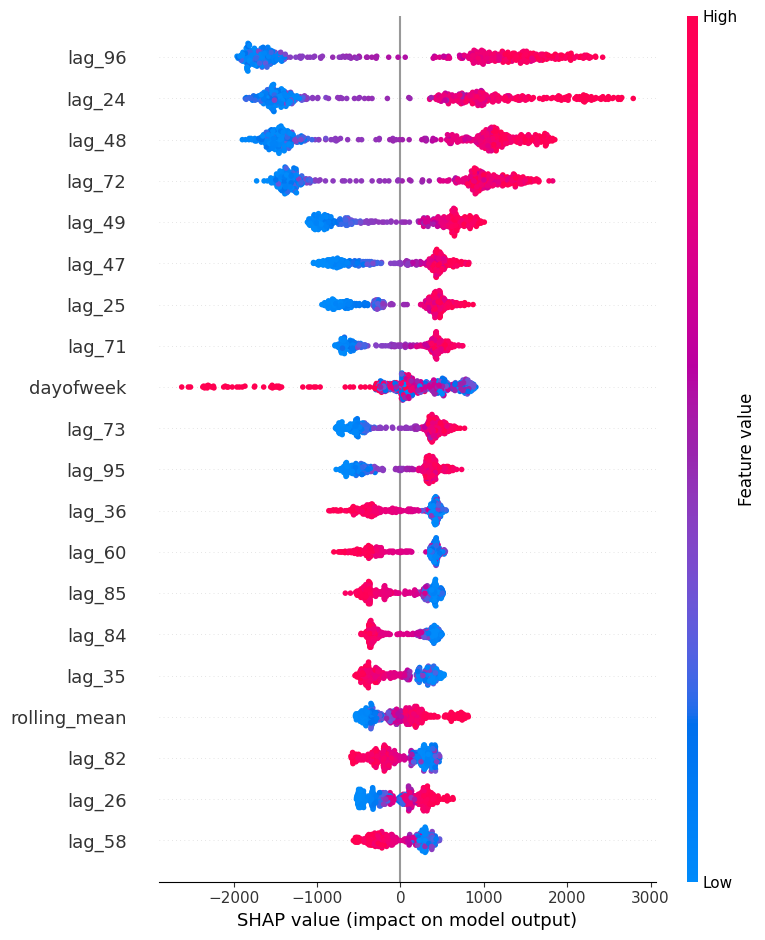

In [80]:
shap.summary_plot(shap_values, tra_va.drop("counter_data",axis = 1))

важный нюанс шап делит важность фичей имеющих высокую корреляцию , здесь как раз такой случай , у нас много высококоррелированных фичей (можно сделать профилинг и показать это) следовательно стоит понимать что эти 3 фичи нужно интерпретировать как одну (при описание) . А это значит что для нашей модели важнее всего какое значение было за предыдущие 3 суток в это же время +- час , также день недели играет сильную роль

In [81]:
gr = cb_model.get_feature_importance(prettified=True)
gr

Feature Id  Importances
0      lag_24    14.402380
1      lag_96    12.843154
2      lag_72    10.593956
3      lag_48     9.287911
4   dayofweek     3.536526
..        ...          ...
71     lag_56     0.215546
72     lag_76     0.212992
73     lag_61     0.212596
74     lag_44     0.210703
75     lag_92     0.172665

[76 rows x 2 columns]

In [82]:
print('train_an')
print(tra_va.drop("counter_data",axis = 1).iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values[0,:], tra_va.drop("counter_data",axis = 1).iloc[0,:])

train_an
hour               16.000000
dayofweek           4.000000
lag_24          40611.544000
lag_25          36898.569667
lag_26          41524.386000
                    ...     
lag_94          45091.751334
lag_95          45465.502000
lag_96          31271.630001
rolling_mean    40211.687933
y_pred          39747.126447
Name: 2022-02-25 16:00:00, Length: 77, dtype: float64


вроде бы все фичи вносят свой вклад , следовательно избежали утечки таргета при добавление фичей 

## Итоговый тест и вывод

лучшая модель catboost , сейчас обучим на tra_va и сделаем предсказание на тесте

In [83]:
tra_va = tra_va.drop('y_pred',axis = 1)

In [84]:
tra_va.shape

(503, 77)

In [85]:
valid.shape

(106, 77)

<div class="alert alert-info">
<h2> Комментарий выполняющего: <a class="tocSkip"> </h2>
хоть и проверка на валидации(часть обучающих данных) переобучение должны избежать , так как используем не чрезмерное количество итераций
</div> 

In [86]:
cb_model = CatBoostRegressor(max_depth=8, iterations=850,
                             early_stopping_rounds=20, 
                             objective="RMSE", 
                             learning_rate = 0.01,
                             verbose=10,
                             random_state=1)

cb_model.fit(tra_va.drop("counter_data",axis = 1), tra_va[['counter_data']], eval_set=(valid.drop("counter_data",axis = 1), valid[['counter_data']]))

0:	learn: 16839.4091958	test: 17413.0492805	best: 17413.0492805 (0)	total: 19.8ms	remaining: 16.9s
10:	learn: 15488.5043942	test: 16069.4987992	best: 16069.4987992 (10)	total: 198ms	remaining: 15.1s
20:	learn: 14254.6640671	test: 14835.7464829	best: 14835.7464829 (20)	total: 382ms	remaining: 15.1s
30:	learn: 13111.1725646	test: 13687.0674698	best: 13687.0674698 (30)	total: 565ms	remaining: 14.9s
40:	learn: 12070.4603063	test: 12630.4227140	best: 12630.4227140 (40)	total: 747ms	remaining: 14.7s
50:	learn: 11116.0832983	test: 11667.2803044	best: 11667.2803044 (50)	total: 930ms	remaining: 14.6s
60:	learn: 10260.1272768	test: 10795.0222804	best: 10795.0222804 (60)	total: 1.11s	remaining: 14.4s
70:	learn: 9468.6717111	test: 9992.9591618	best: 9992.9591618 (70)	total: 1.32s	remaining: 14.5s
80:	learn: 8735.3182236	test: 9251.8008680	best: 9251.8008680 (80)	total: 1.51s	remaining: 14.4s
90:	learn: 8083.4368477	test: 8588.8666460	best: 8588.8666460 (90)	total: 1.69s	remaining: 14.1s
100:	learn

создание датафрема с предиктом , для финальной визуализации

In [87]:
final_plot = cb_model.predict(data.drop("counter_data",axis = 1))

In [88]:
final_plot = pd.DataFrame({'predict':final_plot},index = data.index)

In [89]:
final_plot

predict
counter_timestamp                
2022-02-25 16:00:00  39522.086157
2022-02-25 17:00:00  43956.902372
2022-02-25 18:00:00  43420.840671
2022-02-25 19:00:00  32464.658364
2022-02-25 20:00:00  20249.265515
...                           ...
2022-03-22 20:00:00  18294.287294
2022-03-22 21:00:00  10952.210697
2022-03-22 22:00:00   6898.693440
2022-03-22 23:00:00   4938.780954
2022-03-23 00:00:00   3425.252238

[609 rows x 1 columns]

In [90]:
predict_test = cb_model.predict(test.drop("counter_data",axis = 1))

In [91]:
np.sqrt(mean_squared_error(test['counter_data'].values,predict_test))

1601.3113304237233

итог 1600 на тест (что лучше чем наивная модель)

In [92]:
np.sqrt(mean_squared_error(data['counter_data'],final_plot['predict']))

1120.1087366498841

финальная визуализация

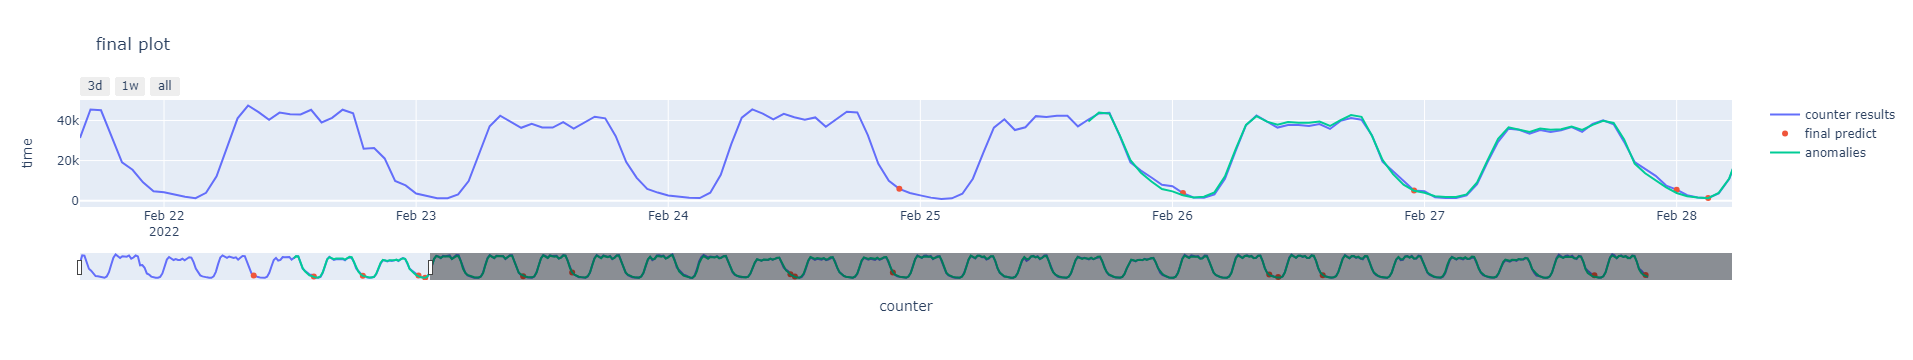

In [93]:
#x_data1 = x=data.index
x_data2 = data_out.index
x_data3 = x=final_plot.index
#y_data_1 = data['counter_data']
y_data_2 = data_out['counter_data']
y_data_3 = final_plot['predict']
# Create traces for each data set
trace1 = go.Scatter(x=x_data1, y=y_data_1, mode='lines', name='counter results')
trace3 = go.Scatter(x=x_data3, y=y_data_3, mode='lines', name='final predict')
trace2 = go.Scatter(x=x_data2, y=y_data_2, mode='markers', name='anomalies')

# Create the figure and add traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3)
# Update layout if needed (e.g., title, axis labels)
fig.update_layout(title='final plot',
                  xaxis_title='counter',
                  yaxis_title='time')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"),
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

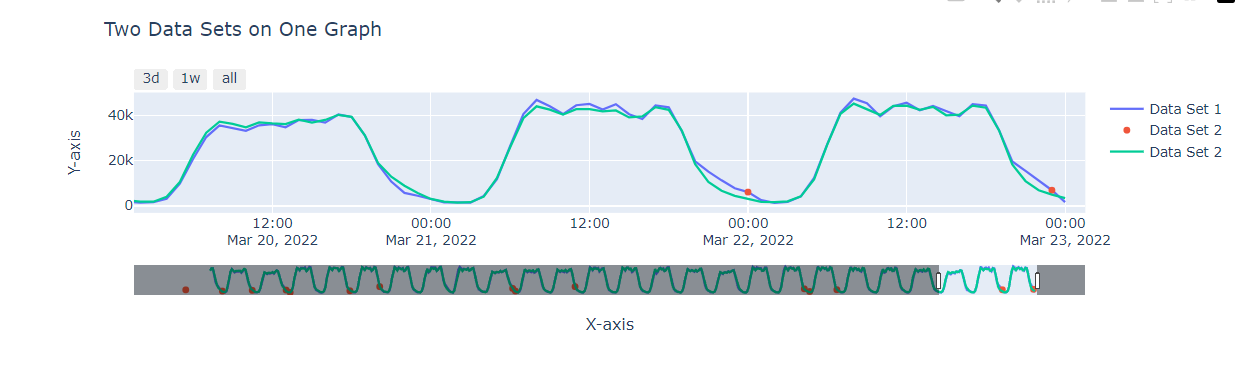

общий вывод:
основная информация с которой мы работали это показатели счётчика и времени , также для построенние некоторых моделей были сгенерированны столбцы (с скользящим среднем , часом , днём недели и данные о истиноом значение какое-то время назад(1сутки-4 суток))
<br>итог эксперементов с моделями: использовами prophet , rnn , catboost , лучше всего себя показал catboost (rmse 1600 на тесте при показателях 2900 наивной модели)
<br>Рекомендации: собрать хотя бы ещё 2 недели данных для улучшения модели